# Tutorial 1: Integrating three simulated slices by SMILE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import stSMILE
from stSMILE import SMILE

In [3]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import squidpy as sq
import scipy.sparse as sp
from scipy import sparse
from scipy.sparse import csr_matrix
import math
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
from itertools import chain
from scanpy import read_10x_h5
import torch.optim as optim
import sklearn
from sklearn.neighbors import kneighbors_graph
import gudhi
import networkx as nx
from torch_geometric.nn import GCNConv
import random
import os
import json 
import matplotlib.image as mpimg


# load data

In [4]:
section_ids = ['S1','S2','S3']
print(section_ids)

['S1', 'S2', 'S3']


In [5]:
adata_l = []
for i in range(len(section_ids)):
    adata_i = sc.read_h5ad('/Users/lihuazhang/Documents/projects/SMILE-main/dataset/simulation/simulated_'+ section_ids[i]+'_ST_final.h5ad')
    adata_i.obs_names = [x+'_'+section_ids[i] for x in adata_i.obs_names]
    cluster = pd.read_csv('/Users/lihuazhang/Documents/projects/SMILE-main/dataset/simulation/simulated_' + section_ids[i]+'_true_cluster.csv', sep = '\t')
    cluster.index = adata_i.obs_names
    adata_i.obs['Ground Truth'] = pd.Series(cluster['0'])    
    adata_i.obs['Ground Truth'] = adata_i.obs['Ground Truth'].astype(str)
    adata_i.obs['Ground Truth'] = adata_i.obs['Ground Truth'].astype('category')
    adata_l.append(adata_i)

In [6]:
adata0_sc = sc.read_h5ad('/Users/lihuazhang/Documents/projects/SMILE-main/dataset/simulation/simulated_sc_final.h5ad') 

In [7]:
adata_l.append(adata0_sc)

In [8]:
len(adata_l)

4

# Run SMILE

In [9]:
in_features = len(adata_l[0].var.index)
hidden_features = 512
out_features = 50

In [10]:
tag_l = ['ST','ST','ST','single cell']

In [11]:
feature_method = 'GCNConv'
alpha = 1
beta = 1
gamma = 1000
lamb = 1
theta = 0.9
spatial_regularization_strength= 0.9
lr=1e-3
subepochs=100
epochs=200
max_patience=50
min_stop=20
random_seed=2024
gpu=0
regularization_acceleration=True
edge_subset_sz=1000000

In [12]:
add_topology = True
add_feature = False
add_image = False
add_sc = True

In [13]:
multiscale = True

In [14]:
anchor_type = None
anchors_all = False
use_rep_anchor = 'deconvolution'
align_method = 'MMD'
anchor_size=8000

In [15]:
iter_comb= None
n_clusters_l = [4]
edge_weights = [1,0.1,0.1]

In [16]:
adata_l = SMILE(adata_l, tag_l, section_ids, multiscale,  n_clusters_l, in_features, feature_method, hidden_features, out_features, iter_comb, anchors_all, use_rep_anchor, alpha, beta, lamb, theta, gamma,edge_weights, add_topology, add_feature, add_image, add_sc, spatial_regularization_strength, lr=0.001, subepochs=100, epochs=200,mnn_neigh = 5)

Pretraining to extract embeddings of spots...
epoch   0: train spatial C loss: 0.0000, train F loss: 4.8514,
epoch  10: train spatial C loss: 0.0000, train F loss: 2.2220,
epoch  20: train spatial C loss: 0.0000, train F loss: 1.4567,
epoch  30: train spatial C loss: 0.0000, train F loss: 1.0723,
epoch  40: train spatial C loss: 0.0000, train F loss: 0.8445,
epoch  50: train spatial C loss: 0.0000, train F loss: 0.7221,
epoch  60: train spatial C loss: 0.0000, train F loss: 0.6632,
epoch  70: train spatial C loss: 0.0000, train F loss: 0.6334,
epoch  80: train spatial C loss: 0.0000, train F loss: 0.5898,
epoch  90: train spatial C loss: 0.0000, train F loss: 0.5745,
Training classifier...
Training classifier...
torch.Size([490, 7])
torch.Size([490, 7])
torch.Size([490, 7])
epoch   0: overall loss: 37.6162,sc classifier loss: 1.9628,representation loss: 0.0356,within spatial regularization loss: 0.0980
torch.Size([490, 7])
torch.Size([490, 7])
torch.Size([490, 7])
torch.Size([490, 7])


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Identifying anchors...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)
0.9805634888254228
The ratio of filtered mnn pairs: 1.0
The ratio of filtered mnn pairs: 0.96
The ratio of filtered mnn pairs: 0.9603803486529319
Aligning by anchors...
epoch 100: total loss:4.3614, train F loss: 1.3807, train C loss: 1.3639, train D loss: 2.9807
epoch 110: total loss:1.1600, train F loss: 0.9650, train C loss: 0.3505, train D loss: 0.1950
epoch 120: total loss:1.1445, train F loss: 1.0216, train C loss: 0.1893, train D loss: 0.1229
epoch 130: total loss:0.7761, train F loss: 0.6795, train C loss: 0.0317, train D loss: 0.0966
epoch 140: total loss:0.6860, train F loss: 0.6034, train C loss: 0.0109, train D loss: 0.0826
epoch 150: total loss:0.6461, train F loss: 0.5806, train C loss: 0.0078, train D loss: 0.0656
epoch 160: total loss:0.6199, train F loss: 0.5719, train C loss:

In [17]:
adata_concat_st = ad.concat(adata_l[0:len(section_ids)], label="slice_name", keys=section_ids)

In [18]:
adata_concat_st.obs['pd_cluster'] = adata_concat_st.obs['pd_cluster'].astype(str)
adata_concat_st.obs['pd_cluster'] = adata_concat_st.obs['pd_cluster'].astype('category')

In [19]:
sc.tl.pca(adata_concat_st)
adata_concat_st.obsm['X_pca_old'] = adata_concat_st.obsm['X_pca'].copy()
adata_concat_st.obsm['X_pca'] = adata_concat_st.obsm['embedding'].copy()
sc.pp.neighbors(adata_concat_st)  
sc.tl.umap(adata_concat_st)

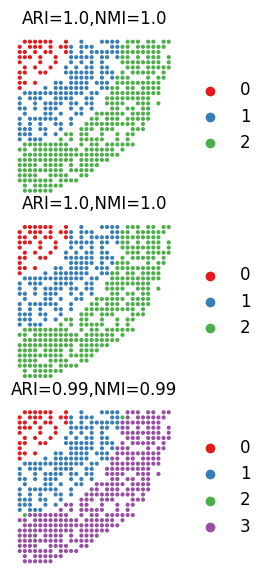

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import normalized_mutual_info_score as nmi_score
import seaborn as sns
rgb_values = sns.color_palette("Set1", len(adata_concat_st.obs['pd_cluster'].unique()))
color_fine = dict(zip(list(adata_concat_st.obs['pd_cluster'].unique()), rgb_values))
Batch_list = []
for section_id in section_ids:
    Batch_list.append(adata_concat_st[adata_concat_st.obs['slice_name'] == section_id])

spot_size = 0.8
title_size = 12
ARI_list = []
NMI_list = []
for bb in range(len(section_ids)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['pd_cluster']), 2))
    NMI_list.append(round(nmi_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['pd_cluster']), 2))

fig, ax = plt.subplots(3,1, figsize=(3.5,7), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['pd_cluster'], 
                      legend_loc='right margin', legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size,palette = color_fine)
_sc_0[0].set_title("ARI=" + str(ARI_list[0])+",NMI=" + str(NMI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['pd_cluster'], 
                      legend_loc='right margin', legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size,palette = color_fine)
_sc_1[0].set_title("ARI=" + str(ARI_list[1])+",NMI=" + str(NMI_list[1]), size=title_size)

_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['pd_cluster'], 
                      legend_loc='right margin', legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size,palette = color_fine)
_sc_2[0].set_title("ARI=" + str(ARI_list[2])+",NMI=" + str(NMI_list[2]), size=title_size)

plt.savefig("simulated_spatial_SMILE.pdf") 
plt.show()